In [7]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [8]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime

In [9]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from scipy import stats

In [10]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [11]:
Base = automap_base()
Base.prepare(engine, reflect=True)
inspector=inspect(engine)

In [12]:
Base.classes.keys() 

['measurement', 'station']

In [13]:
measurement=Base.classes.measurement
station=Base.classes.station

In [14]:
session=Session(engine)

In [15]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [16]:
last_date=session.query(measurement.date).order_by(measurement.date.desc()).first()
print(last_date)

('2017-08-23',)


In [17]:
date_object = datetime.strptime(last_date[0], "%Y-%m-%d")
print(date_object)

2017-08-23 00:00:00


In [18]:
date_object_minus_one = datetime(date_object.year-1,date_object.month,date_object.day-1)
date_object_minus_one

datetime.datetime(2016, 8, 22, 0, 0)

In [19]:
last_12_months=[]
after_last_year=session.query(measurement).filter(measurement.date >= date_object_minus_one)
for row in after_last_year:
    last_12_months.append([row.date,row.prcp])

In [20]:
df=pd.DataFrame(last_12_months)
df1=df.rename(columns={0:'Dates',1:'PRCP'})
df2=df1.sort_values('Dates')
df3=df2.set_index('Dates')

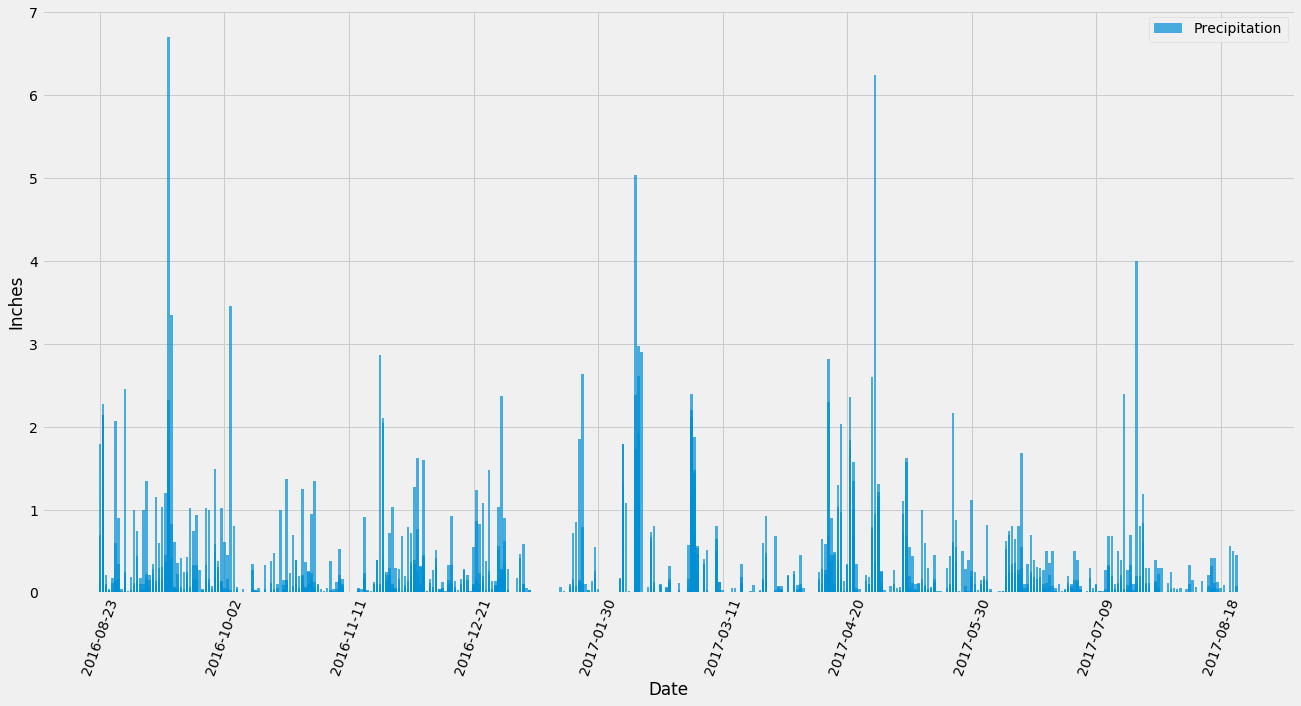

In [21]:
ypos=df3.index
x=df3['PRCP']
fig,ax=plt.subplots(figsize=(20,10))
plt.bar(ypos,x,align='center',alpha=.7)
plt.legend(['Precipitation'])
plt.ylabel('Inches')
plt.xlabel('Date')
ax.set_xticks(ax.get_xticks()[::40])
plt.xticks(rotation=70)
plt.show()

In [22]:
df3.describe()

,PRCP
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


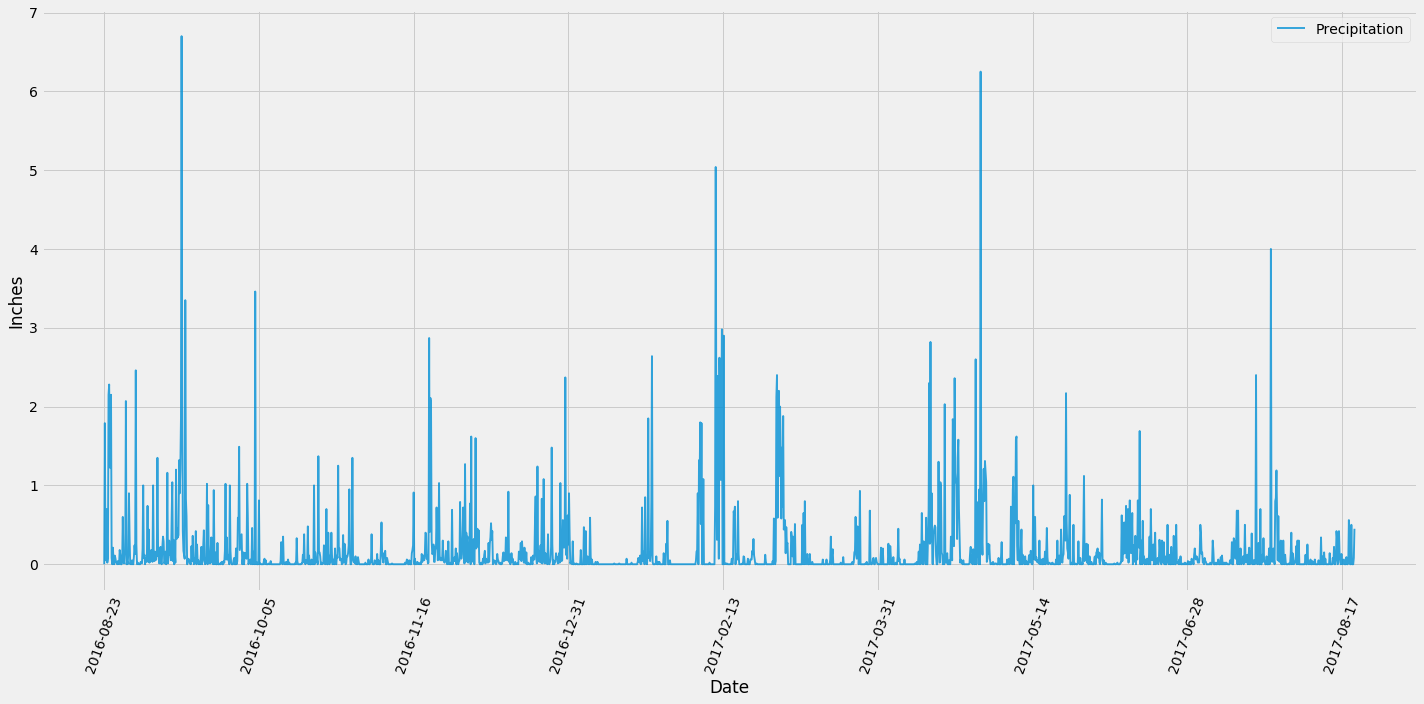

In [23]:
df4=df3.dropna()
ax=df4.plot(y='PRCP',legend=True,rot=70,figsize=(20,10),alpha=.8,linewidth=1.9)
plt.legend(['Precipitation'])
plt.ylabel('Inches')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

In [24]:
df4.describe()

,PRCP
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [25]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [26]:
totalstations=session.query(station.id).count()
print(totalstations)

9


In [27]:
stationlist=[]
stationloop=session.query(station)
for row in stationloop:
    stationlist.append([row.station,row.name,row.latitude,row.longitude,row.elevation])
stationmeasurmentslist=[]
measurementloop=session.query(measurement)
for row2 in measurementloop:
    stationmeasurmentslist.append([row2.station,row2.date,row2.prcp,row2.tobs]) 

In [28]:
stationdf=pd.DataFrame(stationlist)
stationdf2=stationdf.rename(columns={0:'Station',1:'Name',2:'Latitude',3:'Longitude',4:'Elevation'})
measurmentdf=pd.DataFrame(stationmeasurmentslist)
measurmentdf2=measurmentdf.rename(columns={0:'Station',1:'Date',2:'prcp',3:'tobs'})

In [29]:
mergeddf=stationdf2.merge(measurmentdf2, on='Station')

In [30]:
stationcounts=mergeddf['Station'].value_counts()
stationcounts

USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: Station, dtype: int64

In [31]:
grouped=mergeddf.groupby('Station')

In [32]:
lowesttemp=grouped['tobs'].min()
highesttemp=grouped['tobs'].max()
avgtemp=grouped['tobs'].mean()
lowesttemp

Station
USC00511918    53.0
USC00513117    59.0
USC00514830    58.0
USC00516128    58.0
USC00517948    58.0
USC00518838    58.0
USC00519281    54.0
USC00519397    56.0
USC00519523    56.0
Name: tobs, dtype: float64

In [33]:
onestationdf = mergeddf[mergeddf['Station'] == 'USC00519281']
lowesttemp2=onestationdf['tobs'].min()
highesttemp2=onestationdf['tobs'].max()
avgtemp2=onestationdf['tobs'].mean()
lowesttemp2

54.0

In [34]:
highesttemp2

85.0

In [35]:
avgtemp2

71.66378066378067

In [36]:
onesorteddf=onestationdf.sort_values('Date', ascending=False)
last_date2=onesorteddf.head(1)
last_date2

,Station,Name,Latitude,Longitude,Elevation,Date,prcp,tobs
14958,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2017-08-18,0.06,79.0


In [37]:
start_date='2016-08-18'
last_year_search= (onesorteddf['Date'] >= start_date)

Text(0.5, 0, 'Tempurature')

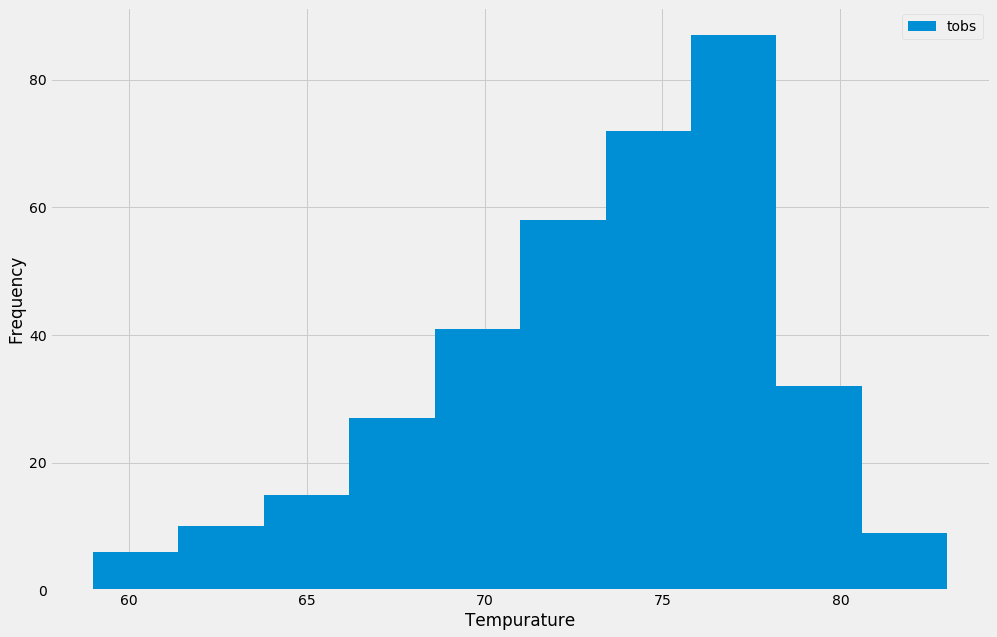

In [38]:
last_year2=onesorteddf.loc[last_year_search]
last_year2temps=pd.DataFrame(last_year2['tobs'])
last_year2dates=pd.DataFrame(last_year2['Date'])
ax3=last_year2['tobs'].plot(kind='hist',figsize=(15,10),legend=True)
plt.xlabel('Tempurature')

In [39]:
mergeddf['Date'] = pd.to_datetime(mergeddf['Date'])
june_dates=mergeddf[mergeddf['Date'].dt.month == 6]
dec_dates=mergeddf[mergeddf['Date'].dt.month == 12]

In [40]:
avg_temp_june=june_dates['tobs'].mean()
avg_temp_dec=dec_dates['tobs'].mean()
print(f'june avg: {avg_temp_june}')
print(f'dec avg: {avg_temp_dec}')


june avg: 74.94411764705882
dec avg: 71.04152933421226


In [41]:
t_stat, p_val = stats.ttest_ind(june_dates['tobs'], dec_dates['tobs'])
print(f't_stat: {t_stat}')
print(f'p_val: {p_val}')

t_stat: 31.60372399000329
p_val: 3.9025129038616655e-191


In [42]:
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
tmin,tavg,tmax=calc_temps('2017-01-01', '2017-01-07')[0]
print(f'{tmin}, {tavg}, {tmax}')

62.0, 68.36585365853658, 74.0


(0, 100)

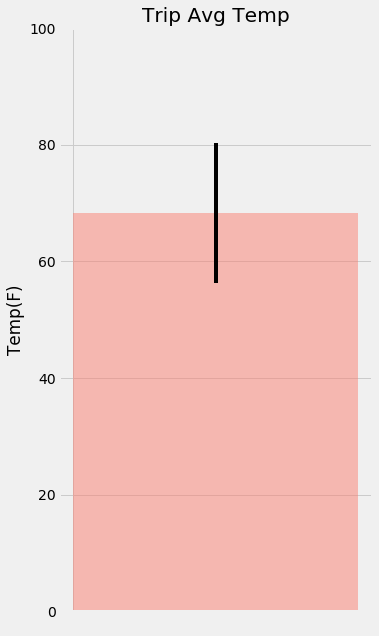

In [43]:
plt.figure(figsize=(5,10))
plt.bar(x=" ",height=tavg,yerr=tmax-tmin,align='edge',alpha=.5,color='salmon')
plt.title('Trip Avg Temp')
plt.ylabel('Temp(F)')
plt.ylim(0,100)

In [44]:
def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [45]:
startdate='2017-01-01'
enddate='2017-01-07'
startobj=dt.datetime.strptime(startdate, '%Y-%m-%d')
endobj=dt.datetime.strptime(enddate, '%Y-%m-%d')

tripdates = []
normals =[]
while (startobj <= endobj):
    tripdates.append(dt.datetime.strftime(startobj,'%Y-%m-%d'))
    datestr = dt.datetime.strftime(startobj,'%m-%d')
    normals.append(list(np.ravel(daily_normals(datestr))))
    startobj = startobj + dt.timedelta(days = 1)
normals

[[62.0, 69.15384615384616, 77.0],
 [60.0, 69.39622641509433, 77.0],
 [62.0, 68.9090909090909, 77.0],
 [58.0, 70.0, 76.0],
 [56.0, 67.96428571428571, 76.0],
 [61.0, 68.96491228070175, 76.0],
 [57.0, 68.54385964912281, 76.0]]

In [46]:
tripdates

['2017-01-01',
 '2017-01-02',
 '2017-01-03',
 '2017-01-04',
 '2017-01-05',
 '2017-01-06',
 '2017-01-07']

In [47]:
df5=pd.DataFrame(normals)
df5['Dates']=tripdates
df5indexed=df5.set_index('Dates')
df5rename=df5indexed.rename(columns={0:'MIN',1:'AVG',2:'MAX'})
df5rename

,MIN,AVG,MAX
Dates,,,
2017-01-01,62.0,69.153846,77.0
2017-01-02,60.0,69.396226,77.0
2017-01-03,62.0,68.909091,77.0
2017-01-04,58.0,70.000000,76.0
2017-01-05,56.0,67.964286,76.0
2017-01-06,61.0,68.964912,76.0
2017-01-07,57.0,68.543860,76.0


Text(0, 0.5, 'Temp')

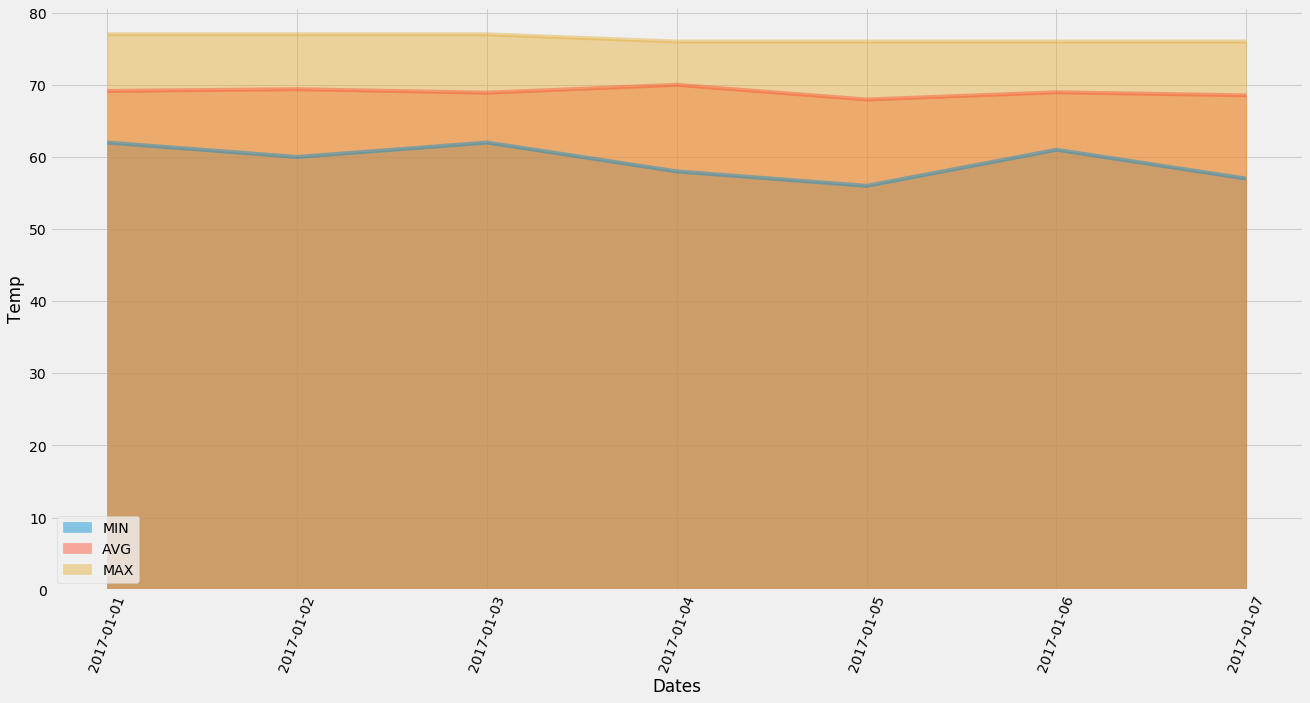

In [48]:
ax=df5rename.plot.area(stacked=False,rot=70,figsize=(20,10),alpha=.45)
ax.set_ylabel('Temp')